In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform,randint
from sklearn.linear_model import LogisticRegressionCV


from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer,matthews_corrcoef,recall_score 

In [2]:
def cross_val(model, X, Y):
    sensitivity_scorer = make_scorer(recall_score)
    specificity_scorer = make_scorer(recall_score, pos_label=0)
    MCC=make_scorer(matthews_corrcoef)


    scoring = {'AUC': 'roc_auc', 'Accuracy': "accuracy", "f1": "f1",
                        "Recall": "recall", "Precision": "precision","MCC":MCC, "Average Precision": "average_precision",
                        "Sensitivity": sensitivity_scorer, "Specificity": specificity_scorer}

    scores=cross_validate(model, X, Y, scoring=scoring,)

    mean_scores = {metric: values.mean() for metric, values in scores.items()}

    #mean_scores_df = pd.DataFrame(list(mean_scores.items()), columns=['Metric', 'Mean Score'])

    return mean_scores

    


# ML classification


## Datasets

In [5]:
complete = pd.read_csv('gene_lists/complete.csv.gz',compression = 'gzip')
cat_1_2_3 = pd.read_csv('gene_lists/cat_1_2_3.csv.gz',compression = 'gzip')
cat_1_2 = pd.read_csv('gene_lists/cat_1_2.csv.gz',compression = 'gzip')
cat_1_2_sd = pd.read_csv('gene_lists/cat_1_2_sd.csv.gz',compression = 'gzip')
cat_1 = pd.read_csv('gene_lists/cat_1.csv.gz',compression = 'gzip')
cat_1_sd = pd.read_csv('gene_lists/cat_1_sd.csv.gz',compression = 'gzip')


## Logistic regression results

In [6]:
def lr_results(datasets):
    results_list = []
    MCC=make_scorer(matthews_corrcoef)

    for dataset,name in datasets:

        x = dataset["3"].copy()
        x = x.str.split(expand=True)
        x= x.astype(float)

        y = dataset["4"].copy().astype('category')

        lr = LogisticRegressionCV(max_iter=10000, class_weight='balanced', scoring=MCC)

        lr_scores = cross_val(lr, x, y)

        result_entry = {'dataset_name': name, **lr_scores}

        results_list.append(result_entry)

    results_df = pd.DataFrame(results_list)
    results_df.set_index('dataset_name', inplace=True)


    return results_df


In [7]:
results_lr=lr_results([(cat_1,"Cat 1"),(cat_1_sd,"Cat 1 and SD"),
                   (cat_1_2,"Cat 1 and 2"),(cat_1_2_sd,"Cat 1 and 2 and SD"),
                   (cat_1_2_3,"Cat 1 and 2 and 3"),(complete,"Complete")])

<Axes: ylabel='dataset_name'>

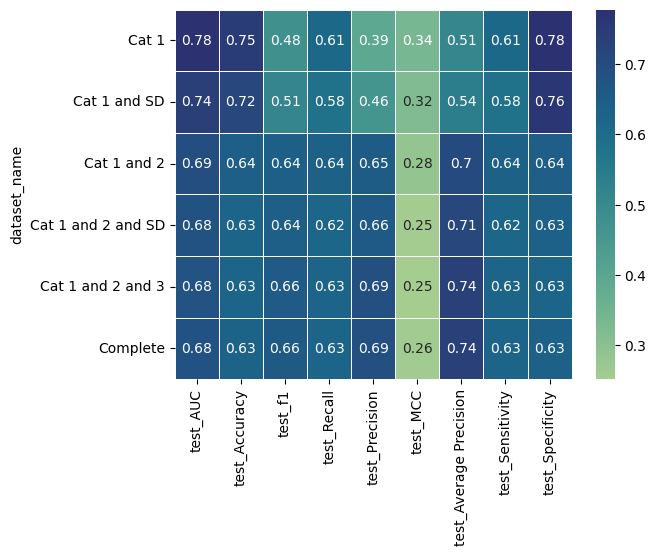

In [8]:
results_lr=results_lr.drop(columns=['fit_time','score_time'])
sns.heatmap(results_lr, cmap="crest", annot=True, linewidths=.5)

In [9]:
import plotly.express as px
fig = px.imshow(results_lr, color_continuous_scale='greens',title='Logistic Regression',width=1000, height=600)
fig.show()  

## LightGBM


In [6]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

def lgbm_results(datasets):
    results_list = []
    MCC = make_scorer(matthews_corrcoef)

    for dataset, name in datasets:
        x = dataset["3"].copy()
        x = x.str.split(expand=True)
        x = x.astype(float)

        y = dataset["4"].copy().astype('category')

        # Define the LightGBM model
        lgb_model = lgb.LGBMClassifier(class_weight='balanced')

        # Define the parameter grid for RandomizedSearchCV
        param_grid = {
            'num_leaves': [31, 127, 255],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 500, 1000],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'subsample': [0.8, 0.9, 1.0],
            'reg_alpha': [0.0, 0.1, 0.5],
            'reg_lambda': [0.0, 0.1, 0.5]
        }

        # Initialize RandomizedSearchCV
        lgb_random = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid,
                                         scoring=MCC, n_iter=10, cv=5, n_jobs=-1)


        lr_scores = cross_val(lgb_random, x, y)

        result_entry = {'dataset_name': name, **lr_scores}

        results_list.append(result_entry)

    results_df = pd.DataFrame(results_list)
    results_df.set_index('dataset_name', inplace=True)


    return results_df

In [7]:
lightgbm_results = lgbm_results([(cat_1,"Cat 1"),(cat_1_sd,"Cat 1 and SD"),])
lightgbm_results

[LightGBM] [Info] Number of positive: 185, number of negative: 632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195804
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be